<a href="https://colab.research.google.com/github/LukasJSvedberg/FMINST-Neural-Network-Project/blob/main/F_MNIST_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import timeit

In [43]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True, # do we want the train set
    download = True, # download yes or no

    transform = ToTensor(),
    target_transform = None # do we want to transform labels
)

test_data = datasets.FashionMNIST(
    root = "data", #
    train = False, # do we want the train set
    download = True, # download, yes or no
    transform = ToTensor(),
    target_transform = None #how to we want to transform the label
)



In [44]:
image, label = train_data[0]

In [45]:
class_names = train_data.classes
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data, shuffle = True, batch_size = 32)
test_dataloader = DataLoader(dataset = test_data, shuffle = False, batch_size = 32)

In [46]:
class FasionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = input_shape,
                      out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units,
                      out_features = output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)



In [47]:
from tensorflow import device
device = "cpu"
model_1 =  FasionMNISTModelV1(input_shape = 784,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)

In [48]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

Loss, optimizer, evaluation metrics

In [49]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [50]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0, 0

  model.train()

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = y,
                             y_pred = y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)

  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss}, train_acc: {train_acc: .3f}$")


In [51]:

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # puts the model into eval mode - can use certain functions

    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to CPU/GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics to calc average loss/accuracy and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.3f}%\n")

In [52]:
torch.manual_seed(100)

# Measure time
from timeit import default_timer as timer
from tqdm.auto import tqdm
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")
  train_step(model = model_1,
             loss_fn = loss_fn,
             data_loader = train_dataloader,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model = model_1,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = train_time_end_on_gpu - train_time_start_on_gpu
print(total_train_time_model_1)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 1.5083612203598022, train_acc:  46.205$
Test loss: 1.44135 | Test accuracy: 47.983%

Epoch: 1
--------
Train loss: 1.332180380821228, train_acc:  51.038$
Test loss: 1.31859 | Test accuracy: 50.779%

Epoch: 2
--------
Train loss: 1.2869664430618286, train_acc:  51.922$
Test loss: 1.29850 | Test accuracy: 51.498%

35.56581491899942


In [53]:
# CNN using TinyVGG architechture
device = "cpu"
class FashionMNISTModelV2(nn.Module):


    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # the size of the square hovering over the image
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value = kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape) # 7*7 required to not cause a shape error

        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x



In [54]:
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [55]:
torch.manual_seed(42)

images = torch.randn(size = (32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image  shape: {test_image.shape}")
print(f"Image: {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image  shape: torch.Size([3, 64, 64])
Image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.7978

In [56]:
torch.manual_seed(42)

conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3,
                       stride = 1,
                       padding = 1)

conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 64, 64])

In [57]:
max_pool_layer = nn.MaxPool2d(kernel_size = 2)

test_image_through_conv = conv_layer(test_image)
print(f"Test image shape: {test_image.shape}")
print(f"Conv layer shape: {test_image_through_conv.shape}")
test_image_through_pool = max_pool_layer(test_image)
print(f"Pool layer shape: {test_image_through_pool.shape}")
test_image_through_both = max_pool_layer(conv_layer(test_image))
print(f"Both layer shape: {test_image_through_both.shape}")

Test image shape: torch.Size([3, 64, 64])
Conv layer shape: torch.Size([10, 64, 64])
Pool layer shape: torch.Size([3, 32, 32])
Both layer shape: torch.Size([10, 32, 32])


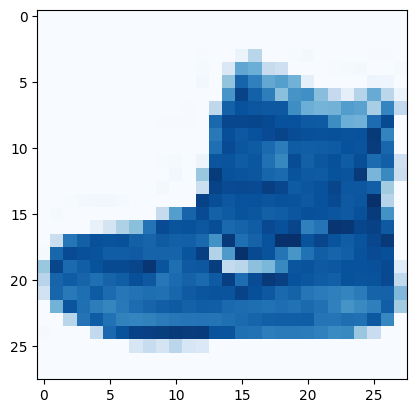

In [58]:
plt.imshow(image.squeeze(), cmap = "Blues")


In [59]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr = 0.1)

model_2.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[-0.1841, -0.1318, -0.2144],
                        [ 0.2159,  0.0372,  0.3180],
                        [-0.0373,  0.2986,  0.1630]]],
              
              
                      [[[-0.0072, -0.1716,  0.1336],
                        [ 0.0185, -0.1685,  0.1939],
                        [-0.0510, -0.3221, -0.1861]]],
              
              
                      [[[ 0.3024,  0.1376, -0.2247],
                        [ 0.2601,  0.0108, -0.3094],
                        [ 0.0984, -0.1046, -0.1212]]],
              
              
                      [[[ 0.0174, -0.3036,  0.0082],
                        [ 0.2701,  0.0659, -0.0367],
                        [ 0.1519, -0.0292, -0.1074]]],
              
              
                      [[[ 0.0808,  0.0353,  0.1264],
                        [-0.0875,  0.2702,  0.2237],
                        [-0.1307,  0.1151,  0.0493]]],
              
              
           

In [60]:
class_names = train_data.classes
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data, shuffle = True, batch_size = 32)
test_dataloader = DataLoader(dataset = test_data, shuffle = False, batch_size = 32)

In [61]:
torch.manual_seed(42)
from timeit import default_timer as timer
from tqdm.auto import tqdm
start_time = timer()

epochs = 3
for epochs in tqdm(range(epochs)):
  print(f"Epoch: {epochs}")
  train_step(model = model_2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)
  test_step(model = model_2,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

end_time = timer()
print(f"Total time: {end_time - start_time}")


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.5872560143470764, train_acc:  78.665$
Test loss: 0.37644 | Test accuracy: 86.392%

Epoch: 1
Train loss: 0.34599626064300537, train_acc:  87.582$
Test loss: 0.33235 | Test accuracy: 88.249%

Epoch: 2
Train loss: 0.308627724647522, train_acc:  88.862$
Test loss: 0.31421 | Test accuracy: 88.948%

Total time: 169.2207975049996


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.289261132478714, train_acc:  89.523$
Test loss: 0.31018 | Test accuracy: 88.708%

Epoch: 1
---------
Train loss: 0.2783859968185425, train_acc:  89.888$
Test loss: 0.30490 | Test accuracy: 88.958%

Epoch: 2
---------
Train loss: 0.27004361152648926, train_acc:  90.162$
Test loss: 0.29175 | Test accuracy: 89.477%

